To install a package over pip so that it works in the notebook you have to run: 
```bash
$ source /opt/tljh/user/bin/activate
$ pip install <package name>
```
and then restart the ipykernal.

Imports

In [1]:
import ferryFile
import port
import numpy as np
import heapq
import scipy
from matplotlib import pyplot as plt 
import matplotlib_inline
import itertools
from typing import Dict, Set
import os
import json
import time
import datetime
import pandas as pd

Load the trip times from the scraped data

In [2]:
def get_date(file_name: str) -> str:
    """Time is in the format of YYYY-MM-DD-HH-MM-SS"""
    return ("-".join(file_name.split("_")[1].split("-")[0:6])).split(".")[0]

def get_week_day(time: str) -> str:
    """Returns 0-6 for monday through sunday for the given date. 
    Expects the time in YYYY-MM-DD-HH-MM-SS"""

    return datetime.datetime.strptime(time, "%Y-%m-%d-%H-%M-%S").weekday()


def load_trip_times_and_ports_from_files(directory: str = None) -> Set: 
    """Returns a set of the ports and dictionary of trip times in minutes with the keys being the route codes + the index of the day of the week, 
    based off the sailing durations in the files."""
    if directory == None: 
        directory = "../BC_Ferries_API_DATA/"

    ports = set()
    trip_times = {}
    
        
    for file in os.listdir(directory):
        with open(directory + file, "r") as f:
            data = json.load(f)
            possible_keys = ['routes', 'capacityRoutes', 'nonCapacityRoutes']
            #print(get_date(file))
            #print(get_week_day(get_date(file)))
            week_day = str(get_week_day(get_date(file)))

            if str(type(data)) == "<class 'str'>":
                #print(f"Type of data is string: {data}")
                #print("Continuing.")
                continue

            if 'routes' in data.keys():
                for route in data['routes']:
                    from_port = route['fromTerminalCode']
                    to_port = route['toTerminalCode']
                    ports.add(from_port)
                    ports.add(to_port)

                    route_code = route['routeCode']
                    assert route_code == from_port + to_port, "Sanity check that the route code is from_port+to_port"

                    route_code = route_code 
                    
                    trip_time = route['sailingDuration']
                    if trip_time == "":
                        #print("Trip time is empty. Continuing")
                        continue
                    if ":" in trip_time: 
                        #then the format is %H:%M
                        hours, minutes = trip_time.split(":")
                    else:
                        #then the format is "%Hh %%Mm"
                        hours, minutes = trip_time.split(" ")
                        hours = hours.strip("h")
                        minutes = minutes.strip("m")

                        

                    trip_time_in_minutes = 60 * int(hours) + int(minutes)

                    # Since the scraped data has multiple routs from one port to another, 
                    # we are only going to pay attention to the direct route, ie take the min
                    if route_code in trip_times.keys():
                        if trip_times[route_code] > trip_time_in_minutes:
                            trip_times[route_code] = trip_time_in_minutes
                    else:
                        trip_times[route_code] = trip_time_in_minutes
                
                    

    return ports, trip_times


PORT_CODES, TRIP_TIMES = load_trip_times_and_ports_from_files()
print(TRIP_TIMES)

{'NANHSB': 100, 'DUKTSA': 120, 'SWBFUL': 35, 'TSADUK': 120, 'HSBNAN': 100, 'HSBLNG': 40, 'PWRCMX': 90, 'SLTERL': 50, 'ERLSLT': 50, 'CMXPWR': 90, 'LNGHSB': 40, 'FULSWB': 35, 'ALRMCN': 40, 'MILBTW': 25, 'TSASWB': 95, 'SWBTSA': 95, 'BTWMIL': 25, 'PPHPPR': 1019, 'PPHPBB': 360, 'PPHSHW': 580, 'PPHBEC': 1095, 'PPHKLE': 690, 'PPHPOF': 800, 'PBBPPH': 390, 'PBBSHW': 45, 'SWBSGI': 40, 'HSBBOW': 20, 'TSASGI': 83, 'PBBPPR': 614, 'KLEPPR': 570, 'POFBEC': 250, 'SHWPBB': 44, 'SHWBEC': 485, 'SHWPOF': 190, 'PBBBEC': 560, 'PBBKLE': 200, 'PBBPOF': 265, 'PPRPBB': 680, 'BECPPH': 1095, 'KLEPBB': 210, 'POFPPH': 780, 'KLEPPH': 660, 'SHWPPH': 585, 'PPRKLE': 560, 'BECSHW': 480, 'POFSHW': 165, 'PPRPPH': 1110, 'POFPBB': 239, 'BECPBB': 554, 'BECPOF': 255}


Constants and Objects

In [3]:
MAX_SIMULATION_TIME = 1000


MEAN_TRIP_TIME = 20
SD_TRIP_TIME = 1.5
MEAN_LOADING_UNLOADING_TIME = 10
SD_LOADING_UNLOADING_TIME = 1


FERRIES = []
SEEDS = [234,4234,324,325543,2,34,546,74,567,568,568,89,364575,342,45,3456473,546,3456473]
SEEDS = set(SEEDS)

# Programmatically create the port objects for each of the port codes
for port_code in PORT_CODES:
    globals()[port_code] = port.Port() 
    globals()[port_code].port_code = port_code


To generate the cdf we can use np.norm.cdf(val, loc, scale) where location is the mean and scale is the standard deviation. 
To find the values for a certain percent we can use ppf from scipy stats

In [4]:
def generate_scheduled_departure_and_arrival_times(arrival, departure, trip_length, wanted_on_time_percent: float = 0.85) -> None:
    trip_distribution = scipy.stats.norm(loc=MEAN_TRIP_TIME, scale=SD_TRIP_TIME)
    loading_unloading_distribution = scipy.stats.norm(loc=MEAN_LOADING_UNLOADING_TIME, scale=SD_LOADING_UNLOADING_TIME)

    current_time = 0
    for i in range(1, trip_length):
        # Add the time to get to the next port
        current_time += trip_distribution.ppf(wanted_on_time_percent)

        # Set the expected arrival time
        arrival[i] = current_time

        # Add the time to load and unload at that port
        current_time += loading_unloading_distribution.ppf(wanted_on_time_percent)

        #Set the expected departure time
        departure[i] = current_time

    for i in range(len(arrival)):
        if type(arrival[i]) not in [int, float]:
            arrival[i] = arrival[i].item()
    for i in range(len(departure)):
        if type(departure[i]) not in [int, float]:
            departure[i] = departure[i].item()
    

In [5]:
expected_arrival = [ 0 for i in range(4)]
expected_departure = [0 for i in range(4)]

generate_scheduled_departure_and_arrival_times(expected_arrival, expected_departure, 4, 0.70)

The ferry must have the same number of departure times as the number of legs * trips.
The ferry must have the same number of departure times as the number of legs * trips.
QNW has completed their trip at time 50.337516914434104.
Total time with the ferry being late to arrive: 13.63768442600584
Total time with the ferry being late to depart: 5.648132395189105
Total times more then 10 increments later then scheduled: 0
The total amount of times the ferry was late at all: 2
The ferry must have the same number of departure times as the number of legs * trips.
The ferry must have the same number of departure times as the number of legs * trips.
QNW has completed their trip at time 48.40937328333042.
Total time with the ferry being late to arrive: 9.370801363255435
Total time with the ferry being late to depart: 6.058728195732133
Total times more then 10 increments later then scheduled: 0
The total amount of times the ferry was late at all: 2
The ferry must have the same number of departure 

<BarContainer object of 99 artists>

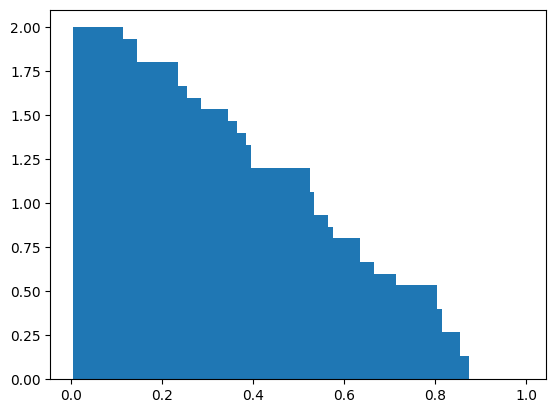

In [6]:
time_to_count_as_late = 0
lates_for_each = {}
for ppf_value in range(1, 100, 1):
    ppf_value = ppf_value / 100
    lates_for_each[ppf_value] = []

    expected_arrival = [ 0 for i in range(4)]
    expected_departure = [0 for i in range(4)]
    generate_scheduled_departure_and_arrival_times(expected_arrival, expected_departure, 4, ppf_value)
    
    for seed_value in SEEDS:
        np.random.seed(seed_value)
        # Most of the trips take the same amount of time independent of the ferry 
        # Makes every port to every other port take 20ish minutes. 
        # Times are made to be the same independent of direction.
        TRIP_TIMES = {}
        for port in PORT_CODES:
            for other_port in [i for i in PORT_CODES if i != port]:
                if other_port + port in TRIP_TIMES.keys():
                    TRIP_TIMES[port+other_port] = TRIP_TIMES[other_port+port]
                else:
                    TRIP_TIMES[port + other_port] = np.random.normal(MEAN_TRIP_TIME, SD_TRIP_TIME)
    
        # Set the loading and unloading times
        # Port + Current_time for every 5 step increment
        LOADING_AND_UNLOADING_TIMES = {}
        for port_code in PORT_CODES:
            for time in range(0, MAX_SIMULATION_TIME, 5):
                LOADING_AND_UNLOADING_TIMES[globals()[port_code] + time] = np.random.normal(MEAN_LOADING_UNLOADING_TIME, SD_LOADING_UNLOADING_TIME)
        

        
        #Create a ferry object
        QNW = ferryFile.Ferry()
        QNW.ferry_name = "Queen of New Westminster"
        QNW.ferry_code = "QNW"
        QNW.ferry_capacity = 150
        QNW.ferry_route = [TSA, SWB, TSA]
        QNW.ferry_trip_time = TRIP_TIMES
        QNW.set_expected_departure_times(expected_departure)
        QNW.set_expected_arrival_times(expected_arrival)
        QNW.loading_unloading_time = LOADING_AND_UNLOADING_TIMES
        QNW.trips_required = 1
        
        QNW.trips_completed = 0
        QNW.ferry_current_port_index = 0
        QNW.validate_arrival_and_departure_times()

        QNW.print_stats_at_end = True

        QNW.validate_arrival_and_departure_times()
    
        current_time =0
        event_queue = []
        heapq.heapify(event_queue)
        heapq.heappush(event_queue, (current_time, QNW))
        
    
        current_event = heapq.heappop(event_queue)
        while current_event[1].next_function != None:
            current_time = current_event[0]
    
            next_event_time = current_event[1].next_function(current_time)
            heapq.heappush(event_queue, (next_event_time, current_event[1]))
    
            current_event = heapq.heappop(event_queue)

        lates_for_each[ppf_value].append(QNW.total_times_late(time_to_count_as_late))




#print(lates_for_each)
for key in lates_for_each.keys():
    data = lates_for_each[key]
    times_late_to_arrive = [i[0] for i in data]
    times_late_to_depart = [i[1] for i in data]

    times_late_to_arrive = sum(times_late_to_arrive) / len(times_late_to_arrive)
    times_late_to_depart = sum(times_late_to_depart) / len(times_late_to_depart)

    lates_for_each[key] = [times_late_to_arrive, times_late_to_depart]
#print(lates_for_each)

plt.bar(lates_for_each.keys(), [lates_for_each[key][0] for key in lates_for_each.keys()], 0.01)

Use pandas to load data from csv - Keep in mind to run this locally, and not upload the files to github or the jupyter server!

In [12]:
#TODO: Change to the actual file being read
data_file = None

#Load data from file
#all_data = pd.read_csv(file)
data = {"date_key": ["2024-04-0" + str(i) for i in range(1,10)]}
for i in range(10,28):
    data["date_key"].append("2024-04-" + str(i))
all_data = pd.DataFrame(data = data)

#Seperate data by day of the week
all_data['day_of_the_week'] = [datetime.datetime.strptime(i, "%Y-%m-%d").weekday() for i in all_data['date_key']]

#Add route code
all_data["route_id"] = np.random.choice([5,9], all_data.shape[0])

all_data.loc[all_data["route_id"] == 5]


,date_key,day_of_the_week,route_id
0,2024-04-01,0,5
1,2024-04-02,1,5
8,2024-04-09,1,5
9,2024-04-10,2,5
10,2024-04-11,3,5
11,2024-04-12,4,5
15,2024-04-16,1,5
17,2024-04-18,3,5
18,2024-04-19,4,5
24,2024-04-25,3,5


In [ ]:
file = None
all_data = pd.read_csv(file)

def convert_to_epoch(date: str):
    dt_obj = datetime.strptime(date, "%Y-%m-%d %H:%M")
    return int(dt_obj.time_stamp())

all_data["arrival_actual_datetime"] = all_data["arrival_actual_datetime"].apply(convert_to_epoch)
all_data["departure_actual_datetime"] = all_data["departure_actual_datetime"].apply(convert_to_epoch)

all_data["sailing_time"] = all_data["arrival_actual_datetime"] - all_data["departure_actual_datetime"]
all_data